In [1]:
from IPython.display import Image
import ee
#import shapefile
import numpy as np
ee.Initialize()

In [2]:
x1=88.993755
y1=22.481707
x2=89.874084
y2=21.720598
polygon1 = [[x1,y1],[x2,y1],[x2,y2],[x1,y2],[x1,y1]]
bd=[[26.595400,88.401549],[25.814693,88.115625],[25.292865,89.014446],[24.674865,88.041039],[21.685379,89.094864],[21.295222,92.640797],[23.690003,92.265045],[22.945747,91.575422],[23.944494,91.213806],[25.009897,92.385592],[25.253268,89.859716],[26.155146,89.739029]]
polygon=polygon1
geo=ee.Geometry.Polygon(polygon)
feat=ee.FeatureCollection(geo)
#print(lon_lat)

In [3]:
import pandas as pd
#MODIS/051/MCD12Q1
#MODIS/006/MCD15A3H
#'LANDSAT/LC8_L1T_TOA'
data='MODIS/006/MCD15A3H'
landsat8_collection = ee.ImageCollection(data)
landsat8_collection_dt=landsat8_collection.filterDate('2006-01-01', '2006-02-28')
final_coll=landsat8_collection_dt
lst_img=final_coll.toList(final_coll.size())
images=[]
n=(final_coll.size().getInfo())
#image2 = image1.select(['Land_Cover_Type_1'])
print(n)

15


In [4]:
root='sb_modis_Lai_2005_18_test/'

In [5]:
names=[]
for i in range(n):
        image=ee.Image(lst_img.get(i))
        images.append(image)
        inf=images[i].getInfo()
        id_img=inf['id']
        name=id_img.split('/')[-1]
        names.append(name)
        print(name)
print(names[:])

2006_01_01
2006_01_05
2006_01_09
2006_01_13
2006_01_17
2006_01_21
2006_01_25
2006_01_29
2006_02_02
2006_02_06
2006_02_10
2006_02_14
2006_02_18
2006_02_22
2006_02_26
['2006_01_01', '2006_01_05', '2006_01_09', '2006_01_13', '2006_01_17', '2006_01_21', '2006_01_25', '2006_01_29', '2006_02_02', '2006_02_06', '2006_02_10', '2006_02_14', '2006_02_18', '2006_02_22', '2006_02_26']


In [6]:
f=open(root+'names_00-06.csv','w')
for name in names:   
    f.write(name)
    f.write('\n')
f.close()

In [7]:
import pickle

pickle_out = open(root+"images_00_06.pickle","wb")
pickle.dump(images, pickle_out)
pickle_out.close()

pickle_out = open(root+"names_00_06.pickle","wb")
pickle.dump(names, pickle_out)
pickle_out.close()




In [8]:
from IPython.display import Image
import ee
#import shapefile
import numpy as np
ee.Initialize()
import pickle
pickle_out = open(root+"names_00_06.pickle","rb")
names=pickle.load(pickle_out)
pickle_out.close()
pickle_out = open(root+"images_00_06.pickle","rb")
images=pickle.load(pickle_out)
pickle_out.close()
n=len(names)
print(n)

15


In [9]:
im=images[0]#.clip(feat)
inf=im.getInfo()
print(inf['properties']['system:footprint']['coordinates'])

[[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]


In [10]:
import requests,urllib
for i in range(n):
    image_a=images[i]
    #tct = tasseled_cap_transformation(images[i])
    #tct_g=tct.select('greenness')
    image = image_a.clip(feat)
    path = image.getDownloadUrl({
        'scale': 250,
        'crs': 'EPSG:4326',#WGS84
        'region':polygon
        })
    print(i)
    res=urllib.request.urlopen(path)
    f=open(root+str(i)+'.zip','wb')
    f.write(res.read())
    f.close()
#request = urllib2.Request(self.url)
#pic = urllib2.urlopen(request)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [11]:
import zipfile
for i in range(n):
    print(i)
    with zipfile.ZipFile(root+str(i)+'.zip', 'r') as zip_ref:
        zip_ref.extractall(root)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [12]:
f=open(root+'names_00-06.csv','r')
lines =f.read()
names=lines.split('\n')
f.close()
print(len(names))

16


In [13]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np


In [14]:
qcs=[]
lai=[]
fapr=[]
qc_names=[]
for name in names:
    if len(name)==0:
        break
    _name=name#+'.Nadir_Reflectance'
    blue=Image.open(root+_name+'.Fpar.tif')
    blue=np.array(blue,dtype=np.uint8)
    green=Image.open(root+_name+'.Lai.tif')
    green=np.array(green,dtype=np.uint8)
    red=Image.open(root+_name+'.FparLai_QC.tif')
    red=np.array(red,dtype=np.uint8)
    #blue=blue*0
    sp=red.shape
    mask=np.ones((sp[0],sp[1]),dtype=np.uint8)
    mask=mask*24
    red=np.bitwise_and(red,mask)
    blue[green>100]=0
    green[green>100]=0

    
    dt=name.split('_')
    month=dt[1]
    if int(month)>=3 and int(month)<=10:
        continue
    qc=np.mean(red)
    #if qc>15:
    #    continue
    qcs.append(qc)
    lai.append(np.mean(green))
    fapr.append(np.mean(blue))
    qc_names.append(name)
    img=np.zeros((sp[0],sp[1],3),dtype=np.uint8)
    red=red*0
    blue=blue*0
    #red[green>248]=255
    img[:,:,0]=np.uint8(blue)
    img[:,:,1]=np.uint8(green*2.5)
    img[:,:,2]=np.uint8(red)
    img[img<-500]=0
    #img=np.uint8(img*255)
    #plt.imshow(img)
    #plt.show()
    cv2.imwrite(root+'img_no_cd/'+name+'.jpg',img)
    print(name,names.index(name))
    print(np.max(img))
    print(np.shape(img))
#print('mean_qc',np.mean(qcs))

2006_01_01 0
162
(340, 393, 3)
2006_01_05 1
167
(340, 393, 3)
2006_01_09 2
175
(340, 393, 3)
2006_01_13 3
162
(340, 393, 3)
2006_01_17 4
155
(340, 393, 3)
2006_01_21 5
150
(340, 393, 3)
2006_01_25 6
135
(340, 393, 3)
2006_01_29 7
140
(340, 393, 3)
2006_02_02 8
140
(340, 393, 3)
2006_02_06 9
157
(340, 393, 3)
2006_02_10 10
107
(340, 393, 3)
2006_02_14 11
147
(340, 393, 3)
2006_02_18 12
175
(340, 393, 3)
2006_02_22 13
160
(340, 393, 3)
2006_02_26 14
135
(340, 393, 3)


In [15]:
print(len(qc_names))

15


In [16]:
import datetime
times=[]
n_times=[]
for name in qc_names:
    if len(name)==0:
        break
    dt=name.split('_')
    time=datetime.datetime(int(dt[0]),int(dt[1]),int(dt[2]))
    times.append(time)
    
    dtt=int(int(dt[0])%2000)+(int(dt[1])/100)+(int(dt[2])/10000)
    dtt=int(dtt*10000)
    #dtt=np.around(dtt,decimals=4)
    n_times.append(dtt)
    #print(time,dtt)
print(n_times)

[60100, 60104, 60108, 60112, 60116, 60121, 60125, 60129, 60202, 60206, 60210, 60214, 60218, 60222, 60226]


In [17]:
print(len(qcs))

15


In [18]:
import pickle
import pandas as pd
n_times=np.array(range(0,len(qcs)))
df=pd.DataFrame([],index=times)
df['qc']=qcs
df['Lai']=lai
df['Fapr']=fapr
pickle_out = open("df_mean_sb.pickle","wb")
pickle.dump(df, pickle_out)
pickle_out.close()


In [19]:
import pickle
import pandas as pd
pickle_out = open("df_mean_sb.pickle","rb")
df=pickle.load(pickle_out)
pickle_out.close()

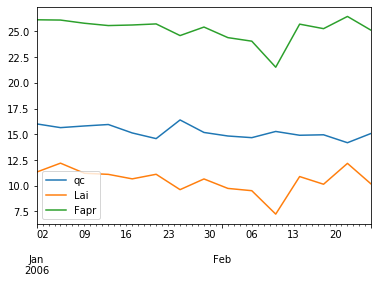

In [20]:
#df['qc']=qc_names

#df=df.rolling(window=50).mean()


df[:200].plot()
df.to_csv(root+'lai_fpar_all.csv',sep=',')
#print(df[:100])